In [1]:
import glob
import pandas as pd

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
path = '../Downloads/CSVs/' # use your path
allFiles = glob.glob(path + "/*.csv")
frame = pd.DataFrame()
list_ = []
for file_ in allFiles:
    print(file_)
    try:
        df = pd.read_csv(file_,index_col=None, header=0)
    except:
        df = pd.read_csv(file_,index_col=None, header=0, encoding = 'latin1')
    list_.append(df)
frame = pd.concat(list_)

../Downloads/CSVs/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv


/Users/ozalmanson/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


../Downloads/CSVs/Monday-WorkingHours.pcap_ISCX.csv


/Users/ozalmanson/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


../Downloads/CSVs/Friday-WorkingHours-Morning.pcap_ISCX.csv
../Downloads/CSVs/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
../Downloads/CSVs/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv


/Users/ozalmanson/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (20,21,85) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


../Downloads/CSVs/Tuesday-WorkingHours.pcap_ISCX.csv
../Downloads/CSVs/Wednesday-workingHours.pcap_ISCX.csv
../Downloads/CSVs/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv


/Users/ozalmanson/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0,1,3,6,20,21,84) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
import numpy as np

In [5]:
frame = frame.dropna(how = 'all')

In [6]:
frame[' Flow Packets/s'] = frame[' Flow Packets/s'].astype('float64')
frame['Flow Bytes/s'] = frame['Flow Bytes/s'].astype('float64')
frame = frame.drop(' Timestamp', axis = 1)
frame = frame.replace([np.inf, -np.inf], np.nan)

In [7]:
#frame = frame.merge(dest_ip_num, left_index = True, right_index = True)
#frame = frame.merge(src_ip_num, left_index = True, right_index = True)

In [8]:
non_trainable = ['Flow ID', ' Source IP', ' Destination IP', ' Timestamp', 'External IP', ' Label', 'dest_a','dest_b','dest_c','dest_d','src_a','src_b', 'src_c','src_d']

In [9]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

/Users/ozalmanson/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Multi Class LSTM

##### creating the multi class labels as one-hot encoding

In [10]:
label_mapping = {val: i for i, val in enumerate(list(frame[' Label'].drop_duplicates()))}
y_all = frame[' Label'].replace(label_mapping)
y_all = y_all.as_matrix()

In [11]:
y_all = to_categorical(y_all)

In [12]:
frame_mat = frame[[col for col in frame.columns if col != ' Label' and col not in non_trainable]].as_matrix()
frame_tsteps = frame_mat.reshape((frame_mat.shape[0], 1, frame_mat.shape[1]))

In [13]:
X_train, X_test, y_train, y_test = train_test_split(frame_tsteps, y_all, test_size=0.2, shuffle = True, random_state=42)

In [14]:
from sklearn.preprocessing import StandardScaler

In [15]:
scaler = StandardScaler()

In [16]:
scaled_train_X = scaler.fit_transform(np.nan_to_num(X_train.reshape((X_train.shape[0], X_train.shape[2]))))

In [17]:
scaled_test_X = scaler.transform(np.nan_to_num(X_test.reshape((X_test.shape[0], X_test.shape[2]))))

In [101]:
y_test.shape

(566149, 15)

In [19]:
scaled_train_X = scaled_train_X.reshape((scaled_train_X.shape[0], 1, scaled_train_X.shape[1]))
scaled_test_X = scaled_test_X.reshape((scaled_test_X.shape[0], 1, scaled_test_X.shape[1]))

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from matplotlib import pyplot
# design network
model = Sequential()
model.add(LSTM(64, input_shape=(scaled_train_X.shape[1], scaled_train_X.shape[2])))
model.add(Dense(32, activation = 'relu'))
#model.add(Dense(32, activation = 'relu'))
model.add(Dense(y_train.shape[1],  activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
print(model.summary())
# fit network
history = model.fit(scaled_train_X, y_train, epochs=10, batch_size=72, validation_data=(scaled_test_X, y_test), verbose=2, shuffle=True)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [86]:
pred = model.predict(scaled_test_X)

In [73]:
from sklearn.metrics import classification_report

In [99]:
print(classification_report(np.argmax(y_test, axis = 1), np.argmax(pred, axis =1)))

             precision    recall  f1-score   support

          0       0.94      1.00      0.97    530659
          9       0.00      0.00      0.00     23006
         10       0.00      0.00      0.00     10293
         11       0.00      0.00      0.00        11
         12       0.00      0.00      0.00      1507
         13       0.00      0.00      0.00       652
         14       0.00      0.00      0.00        21

avg / total       0.88      0.94      0.91    566149



/Users/ozalmanson/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [72]:
from sklearn.metrics import confusion_matrix

In [102]:
print(confusion_matrix(np.argmax(y_test, axis = 1), np.argmax(pred, axis =1)))

[[530659      0      0      0      0      0      0]
 [ 23006      0      0      0      0      0      0]
 [ 10293      0      0      0      0      0      0]
 [    11      0      0      0      0      0      0]
 [  1507      0      0      0      0      0      0]
 [   652      0      0      0      0      0      0]
 [    21      0      0      0      0      0      0]]


## Binary Timesteps LSTM

##### Creating binary label

In [13]:
y_binary = frame[' Label'].apply(lambda val: 1 if val != 'BENIGN' else 0).as_matrix()

##### creating timesteps dataset

In [14]:
seq_length = 2
dataX = []
dataY = []

In [15]:
dataX = [frame_mat[i:i + seq_length] for i in range(len(frame_mat) - seq_length)]

In [16]:
dataY = [y_binary[i + seq_length - 1] for i in range(len(frame_mat) - seq_length)]

In [17]:
data_X_tsteps = np.array(dataX)

In [18]:
data_y_tsteps = np.array(dataY)

##### dataset shape is (Samples, Timesteps, Features)

In [19]:
data_X_tsteps.shape

(2830741, 2, 80)

In [80]:
X_train, X_test, y_train, y_test = train_test_split(np.nan_to_num(data_X_tsteps), data_y_tsteps, test_size=0.2, shuffle = True, random_state=42)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_37 (LSTM)               (None, 64)                37120     
_________________________________________________________________
dense_73 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_74 (Dense)             (None, 1)                 33        
Total params: 39,233
Trainable params: 39,233
Non-trainable params: 0
_________________________________________________________________
None
Train on 2264592 samples, validate on 20000 samples
Epoch 1/100
 - 143s - loss: 0.1693 - val_loss: 0.1621
Epoch 2/100
 - 142s - loss: 0.1590 - val_loss: 0.1590
Epoch 3/100
 - 136s - loss: 0.1535 - val_loss: 0.1506
Epoch 4/100
 - 153s - loss: 0.1505 - val_loss: 0.1460
Epoch 5/100
 - 137s - loss: 0.1421 - val_loss: 0.1402
Epoch 6/100
 - 138s - loss: 0.1434 - val_loss: 0.1291
Epoch 7/100
 - 139s -

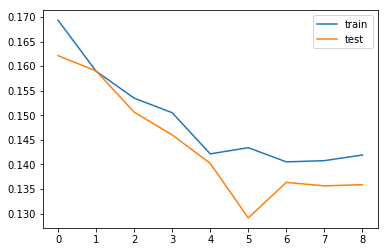

In [87]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from matplotlib import pyplot
# design network
model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(32, activation = 'relu'))
#model.add(Dense(32, activation = 'relu'))
model.add(Dense(1,  activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam')
print(model.summary())
# fit network
es = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=3,
                              verbose=0, mode='auto')
history = model.fit(X_train, y_train, epochs=100, batch_size=72, validation_data=(X_test[:20000], y_test[:20000]), verbose=2, shuffle=True, callbacks=[es])
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [88]:
pred = model.predict(X_test)

In [89]:
print(classification_report(y_test, list(map(lambda val: 1 if val > 0.5 else 0,pred))))

             precision    recall  f1-score   support

          0       0.96      0.97      0.97    471609
          1       0.86      0.81      0.83     94540

avg / total       0.94      0.95      0.94    566149



In [158]:
print(confusion_matrix(y_test_binary, list(map(lambda val: 1 if val > 0.5 else 0,pred))))

[[511462  19197]
 [  9592  25898]]


## All Attacks PCA

In [18]:
from sklearn.decomposition import PCA

In [19]:
pca = PCA(n_components=3)

In [34]:
scaled_train_X_pca = pca.fit_transform(scaled_train_X)

In [21]:
y_labels = np.array(list(map(np.argmax, y_train)))

In [22]:
import matplotlib.pyplot as plt

In [23]:
from mpl_toolkits.mplot3d import Axes3D

In [61]:
scaled_train_X_pca = np.hstack((scaled_train_X_pca,y_labels.reshape(y_labels.shape[0],1)))

In [62]:
pca_sample = np.nan_to_num(scaled_train_X_pca[np.random.randint(scaled_train_X_pca.shape[0], size=10000), :])

In [63]:
th = 3

In [64]:
pca_sample = np.array([row for row in pca_sample if row[0] < th and row[0] > -th and row[1] < th and row[1] > -th and row[2] < th and row[2] > -th])

In [ ]:
pca_sample = 

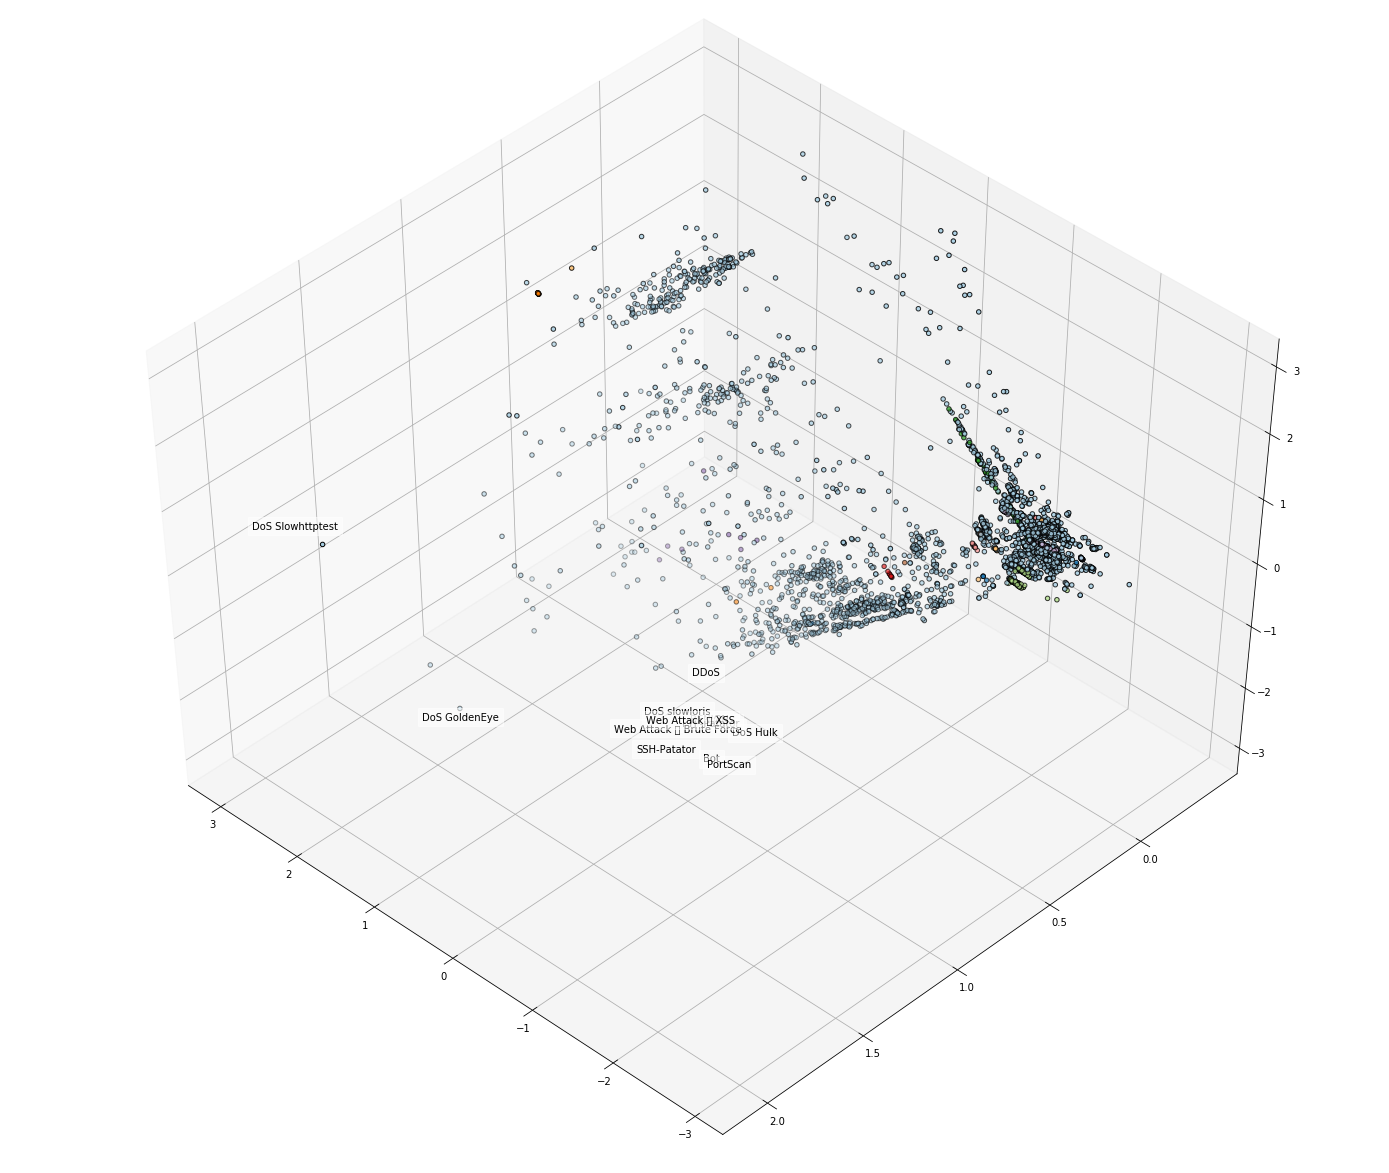

In [67]:
fig = plt.figure(1, figsize=(20,16))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
plt.cla()
for name, label in list(label_mapping.items()):
    if(len(pca_sample[pca_sample[:,3] == label]) >0):
        ax.text3D(pca_sample[pca_sample[:,3] == label, 0].mean(),
                  pca_sample[pca_sample[:,3] == label, 1].mean() + 1.5,
                  pca_sample[pca_sample[:,3] == label, 2].mean(), name,
                  horizontalalignment='center',
                  bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
# Reorder the labels to have colors matching thscaled_train_X_pcae cluster results
#y = np.choose(cleaned_data[:,3], [1, 0]).astype(np.float)
ax.scatter(pca_sample[:, 0],pca_sample[:, 1], pca_sample[:, 2], c=pca_sample[:, 3], cmap=plt.cm.Paired,
           edgecolor='k')

In [46]:
pca_sample[pca_sample[:,3] == 1]

array([], shape=(0, 4), dtype=float64)

In [33]:
scaled_train_X_pca

(2264594, 4)